# Credit Card Customer Clustering

_Author_: QH  
_First Version_: 2022-10-18  
_Latest Updates on_: 2022-11-17

This project uses the dataset from Kaggle (https://www.kaggle.com/datasets/arjunbhasin2013/ccdata) to develop a marketing strategy for credit card users. The dataset contains usage behavior (in total 18 usage behavior variables) of the around 9000 active credit card holders during the last 6 months.

The notebook will follow the steps below to help segmenting customers:
1. Data Cleaning
2. Data Pre-processing for Analysis
3. Clustering and Visualization
4. Interpretation and Recommendation
5. Appendix

## Data Dictionary
For better understanding the dataset, this section includes a data dictionary for the dataset.

|No.| Column Name |Description|
| --- | --- | --- |
|1 |CUST_ID                         |Identification of Credit Card holder (Categorical)|
|2 |BALANCE                         |Balance amount left in their account to make purchases|
|3 |BALANCE_FREQUENCY               |How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)|
|4 |PURCHASES                       |Amount of purchases made from account|
|5 |ONEOFF_PURCHASES                |Maximum purchase amount done in one-go|
|6 |INSTALLMENTS_PURCHASES          |Amount of purchase done in installment|
|7 |CASH_ADVANCE                    |Cash in advance given by the user|
|8 |PURCHASES_FREQUENCY             |How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)|
|9 |ONEOFF_PURCHASES_FREQUENCY      |How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)|
|10|PURCHASES_INSTALLMENTS_FREQUENCY|How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
|11|CASH_ADVANCE_FREQUENCY          |How frequently the cash in advance being paid|
|12|CASH_ADVANCE_TRX                |Number of Transactions made with "Cash in Advanced"|
|13|PURCHASES_TRX                   |Number of purchase transactions made|
|14|CREDIT_LIMIT                    |Limit of Credit Card for user|
|15|PAYMENTS                        |Amount of Payment done by user|
|16|MINIMUM_PAYMENTS                |Minimum amount of payments made by user|
|17|PRC_FULL_PAYMENT                |Percent of full payment paid by user|
|18|TENURE                          |Tenure of credit card service for user|

By a glance of the data dictionary, this data includes how long credit card has been used, the purchase, cash advance (frequency and amount) and payments behavior of clients.

## Python and Library Versions

Import the packages needed for the analysis and print out the versions.

In [1]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import sklearn
import scipy


from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# import utility functions
import sys
# setting path
sys.path.append('../..')
from py_util import util, clustering_util as cutil, preprocessing_util as prep

In [2]:
print('Python version: ' + sys.version)
package_dict = {'Pandas': pd, 'Numpy': np, 'Matplotlib': matplotlib, 'Seaborn': sns, 'Scikit-Learn': sklearn, 'SciPy': scipy}
util.print_version(package_dict)

Python version: 3.9.4 (v3.9.4:1f2e3088f3, Apr  4 2021, 12:32:44) 
[Clang 6.0 (clang-600.0.57)]
Pandas: 1.4.3
Numpy: 1.23.2
Matplotlib: 3.5.3
Seaborn: 0.11.2
Scikit-Learn: 1.1.2
SciPy: 1.9.0


## Data Cleaning and Imputation

This section details the loading of the dataset and basic data checking and cleaning for further pre-processing.

### Dataset High-level Investigation

First step, we read in the data.

In [3]:
cc_seg = pd.read_csv('CC GENERAL.csv')

Print the first 5 rows to get a glance of the data.

In [4]:
cc_seg.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


Next step is to print the information of the data set to Understand the number of rows and columns, missing values and data types of each column. There are in total 8950 observations and CREDIT_LIMIT has 1 missing value, MINIMUM_PAYMENTS has 313 missing values. We will leave the imputation to the Missing Data Imputation Section.

In [5]:
cc_seg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

Except for the CUST_ID column, all the others are numerical columns, we can print out the summary statistics for these columns. Notice that the scales are different which indicates that we may need to do normalization/standardization in later steps.

In [6]:
cc_seg.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


Next, we will take a look if there's any duplicated rows, which in this dataset is none.

In [7]:
cc_seg.duplicated().sum()

0

Next, we print out the number of unique values for each columns to understand better understand the data structure and if there're any categorical variables. It is interesting to see TENURE only has 7 unique values. We can use a barplot to understand the distribution of this variable. And we can confirm that CUST_ID is the primary key for this dataset.



In [8]:
cc_seg.nunique()

CUST_ID                             8950
BALANCE                             8871
BALANCE_FREQUENCY                     43
PURCHASES                           6203
ONEOFF_PURCHASES                    4014
INSTALLMENTS_PURCHASES              4452
CASH_ADVANCE                        4323
PURCHASES_FREQUENCY                   47
ONEOFF_PURCHASES_FREQUENCY            47
PURCHASES_INSTALLMENTS_FREQUENCY      47
CASH_ADVANCE_FREQUENCY                54
CASH_ADVANCE_TRX                      65
PURCHASES_TRX                        173
CREDIT_LIMIT                         205
PAYMENTS                            8711
MINIMUM_PAYMENTS                    8636
PRC_FULL_PAYMENT                      47
TENURE                                 7
dtype: int64

From the count plot of the TENURE below, it is very interesting to know that 85% (7584 / 8950) of the sample has 12 months Tenure using the credit card (Note: month is guessed from the context). It is highly likely that Tenure may not be indicative for segmentation analysis. We will evaluate further in the Clustering Analysis and Visualization section.

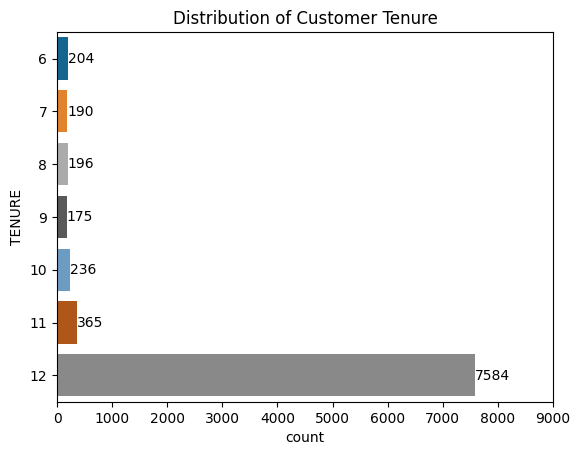

In [9]:
plt.style.use('tableau-colorblind10')
ax = sns.countplot(data = cc_seg, y = 'TENURE')
count_text = ax.bar_label(ax.containers[0])
plt.title('Distribution of Customer Tenure')
ax.set_xlim(0, 9000)
plt.show()

### Data Investigation and Cleaning

In this section, we will do basic data quality checks and perform data correction based on information provided by the dataset.

#### __First Finding__
There are three cases when purchases were made but number of purchase transactions were zero (see below three printed rows). By looking at the amount, one only has a close to zero amount of one-off purchases and the other two have no one-off purchases but with some installments purchases.

In [10]:
cc_seg[(cc_seg['PURCHASES_TRX'] == 0) & (cc_seg['PURCHASES'] > 0)]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
1458,C11506,4.382924,0.272727,130.24,0.00,152.24,0.0,0.083333,0.000000,0.083333,0.0,0,0,14000.0,28988.973880,1092.184812,0.500000,12
3590,C13691,1.869435,0.454545,0.24,0.24,0.00,0.0,0.083333,0.083333,0.000000,0.0,0,0,3000.0,150.381107,53.294711,0.000000,12
4497,C14622,72.425884,1.000000,655.68,0.00,655.68,0.0,1.000000,0.000000,1.000000,0.0,0,0,1000.0,718.537117,162.732686,0.333333,12


One of the way to make informed correction on the number of purchase transactions:
1) For the second case with close to zero one-off purchases, we can assume it was only done in 1 transaction because of the tiny amount.
2) For the other two cases with no one-off but installments purchases, we can use the median of customers with no one-off purchases to impute. As a result, for customer C11506, we will use 6 (median for 100 - 200 installments purchases) while for customer C14622, we will use 12 (median for 600 - 700 installments purchases). See the following code for the computation.

In [11]:
# Same group of customers: No one-off purchases
temp_data = cc_seg[cc_seg['ONEOFF_PURCHASES'] == 0 & (~cc_seg['CUST_ID'].isin(['C11606', 'C14622']))]
# Create categorys to bucket the installments purchases
bins = pd.IntervalIndex.from_tuples([(-0.00001, 0), (0, 100), (100, 200), (200, 300), (300, 400), (400, 500), (500, 600), (600, 700), (700, np.inf)])
installments_label = pd.cut(temp_data['INSTALLMENTS_PURCHASES'], bins)
temp_data = temp_data.assign(installments_seg = installments_label)
# Use the median of the group to impute
temp_data.groupby('installments_seg').agg({'INSTALLMENTS_PURCHASES': ['count', 'mean'], 'PURCHASES_TRX': 'median'})

INSTALLMENTS_PURCHASES              PURCHASES_TRX
                                  count         mean        median
installments_seg                                                  
(-1e-05, 0.0]                      2042     0.000000           0.0
(0.0, 100.0]                        350    60.056257           3.0
(100.0, 200.0]                      362   148.644696           6.0
(200.0, 300.0]                      348   252.182644           9.0
(300.0, 400.0]                      254   349.769291          10.0
(400.0, 500.0]                      208   450.426875          12.0
(500.0, 600.0]                      162   551.211605          12.0
(600.0, 700.0]                       99   648.141010          12.0
(700.0, inf]                        477  1503.195556          13.0

#### __Second Finding__

There are two cases that when there are installment purchases but zero purchases.

For these two cases, to make informed correction, We will change the purchases amount to be the installment purchases amount since there are no one-off purchases.

In [12]:

cc_seg[(cc_seg['PURCHASES'] == 0) & (cc_seg['INSTALLMENTS_PURCHASES'] > 0)]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
4682,C14810,1089.795044,1.0,0.0,0.0,20.00,38.249993,0.0,0.0,0.166667,0.083333,1,1,1200.0,284.731156,331.103830,0.0,12
5737,C15897,10243.147630,1.0,0.0,0.0,66.95,4501.067550,0.0,0.0,0.083333,0.250000,5,0,13000.0,1882.490974,5624.605818,0.0,12


#### __Third Finding__

Same two cases as the second finding that when there are installment purchases frequency but zero purchases frequency.

For these two cases, to make informed correction, we will change the purchases frequency to be the installment purchases frequency since there are no one-time purchases.

In [13]:

cc_seg[(cc_seg['PURCHASES_FREQUENCY'] == 0) & (cc_seg['PURCHASES_INSTALLMENTS_FREQUENCY'] > 0)]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
4682,C14810,1089.795044,1.0,0.0,0.0,20.00,38.249993,0.0,0.0,0.166667,0.083333,1,1,1200.0,284.731156,331.103830,0.0,12
5737,C15897,10243.147630,1.0,0.0,0.0,66.95,4501.067550,0.0,0.0,0.083333,0.250000,5,0,13000.0,1882.490974,5624.605818,0.0,12


#### __Fourth Finding__

There are 19 cases that purchases are not the sum of one-off purchases and installments purchases.  This includes the two cases in finding 2 and 3.

For these cases, we will change the Purchases to be the sum of the two.

In [14]:
cc_seg[(cc_seg['PURCHASES'].round(3) != (cc_seg['ONEOFF_PURCHASES'] + cc_seg['INSTALLMENTS_PURCHASES']).round(3))]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
510,C10533,32.042424,0.909091,400.41,0.00,489.39,0.000000,0.833333,0.000000,0.750000,0.000000,0,11,4500.0,353.570259,132.131820,0.666667,12
745,C10772,1544.979869,1.000000,880.19,0.00,927.45,0.000000,1.000000,0.000000,1.000000,0.000000,0,46,1500.0,1189.503063,1104.152962,0.000000,12
908,C10940,939.152528,1.000000,3393.25,3364.59,77.66,0.000000,0.250000,0.250000,0.083333,0.000000,0,5,9000.0,2768.821579,267.093439,0.000000,12
1458,C11506,4.382924,0.272727,130.24,0.00,152.24,0.000000,0.083333,0.000000,0.083333,0.000000,0,0,14000.0,28988.973880,1092.184812,0.500000,12
3987,C14099,2552.597938,1.000000,550.62,0.00,583.95,0.000000,1.000000,0.000000,0.916667,0.000000,0,24,3000.0,478.632499,1080.350480,0.000000,12
4682,C14810,1089.795044,1.000000,0.00,0.00,20.00,38.249993,0.000000,0.000000,0.166667,0.083333,1,1,1200.0,284.731156,331.103830,0.000000,12
5231,C15378,30.692503,0.454545,205.06,0.00,607.76,0.000000,0.916667,0.000000,1.000000,0.000000,0,35,4500.0,163.982192,55.660981,0.000000,12
5356,C15508,3093.592745,1.000000,47.69,82.41,0.00,1438.951061,0.166667,0.083333,0.000000,0.583333,15,1,4100.0,4591.237633,723.343619,0.000000,12
5737,C15897,10243.147630,1.000000,0.00,0.00,66.95,4501.067550,0.000000,0.000000,0.083333,0.250000,5,0,13000.0,1882.490974,5624.605818,0.000000,12
5845,C16009,1613.502125,1.000000,65.60,0.00,112.60,0.000000,0.400000,0.000000,0.300000,0.000000,0,5,5000.0,390.916581,426.142311,0.000000,10


#### Make the correction

We will create a new dataset and make the corresponding correction based on the findings and investigation discussed above.

In [15]:
# Make a correction on the data
cc_seg_correction = cc_seg.copy()
# Finding 1 correction
cc_seg_correction.loc[cc_seg_correction['CUST_ID'] == 'C13691', 'PURCHASES_TRX'] = 1
cc_seg_correction.loc[cc_seg_correction['CUST_ID'] == 'C11506', 'PURCHASES_TRX'] = 6
cc_seg_correction.loc[cc_seg_correction['CUST_ID'] == 'C14622', 'PURCHASES_TRX'] = 12
# Finding 2, 4 correction
cc_seg_correction.loc[(cc_seg_correction['PURCHASES'].round(3) != (cc_seg_correction['ONEOFF_PURCHASES'] + cc_seg_correction['INSTALLMENTS_PURCHASES']).round(3)), 'PURCHASES'] = cc_seg_correction['ONEOFF_PURCHASES'] + cc_seg_correction['INSTALLMENTS_PURCHASES']

# Finding 3 correction
cc_seg.loc[(cc_seg_correction['PURCHASES_FREQUENCY'] == 0) & (cc_seg_correction['PURCHASES_INSTALLMENTS_FREQUENCY'] > 0), 'PURCHASES_FREQUENCY'] = cc_seg_correction['PURCHASES_INSTALLMENTS_FREQUENCY']

# Check if the findings are corrected -> After the correction, there's one more case:
cc_seg_correction[(cc_seg_correction['PURCHASES_TRX'] == 0) & (cc_seg_correction['PURCHASES'] > 0)]


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
5737,C15897,10243.14763,1.0,66.95,0.0,66.95,4501.06755,0.0,0.0,0.083333,0.25,5,0,13000.0,1882.490974,5624.605818,0.0,12


In [16]:
# Use the same method to impute the purchases transactions
cc_seg_correction.loc[cc_seg_correction['CUST_ID'] == 'C15897', 'PURCHASES_TRX'] = 3

Re-check to see if there's no more findings.

In [17]:
cc_seg_correction[(cc_seg_correction['PURCHASES_TRX'] == 0) & (cc_seg_correction['PURCHASES'] > 0)]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE


In [18]:
cc_seg_correction[(cc_seg_correction['PURCHASES'] == 0) & (cc_seg_correction['INSTALLMENTS_PURCHASES'] > 0)]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE


In [19]:
cc_seg_correction[(cc_seg_correction['PURCHASES_FREQUENCY'] == 0) & (cc_seg_correction['PURCHASES_INSTALLMENTS_FREQUENCY'] > 0)]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
4682,C14810,1089.795044,1.0,20.00,0.0,20.00,38.249993,0.0,0.0,0.166667,0.083333,1,1,1200.0,284.731156,331.103830,0.0,12
5737,C15897,10243.147630,1.0,66.95,0.0,66.95,4501.067550,0.0,0.0,0.083333,0.250000,5,3,13000.0,1882.490974,5624.605818,0.0,12


In [20]:
cc_seg_correction[(cc_seg_correction['PURCHASES'].round(3) != (cc_seg_correction['ONEOFF_PURCHASES'] + cc_seg_correction['INSTALLMENTS_PURCHASES']).round(3))]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE


### Missing Value Imputation

Next step we are going to do a basic imputation for the two columns. We can first print some rows of the missing to get some idea of the imputation methods.

#### Credit Limit Missing

From the previous section, we know there's one case with missing Credit Limit. The following code prints out the information of the customer. We will find some useful infomration to help with the imputation.

In [21]:
# Credit Limit missing - only one observation
cc_seg_correction[cc_seg_correction['CREDIT_LIMIT'].isna()]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
5203,C15349,18.400472,0.166667,0.0,0.0,0.0,186.853063,0.0,0.0,0.0,0.166667,1,0,NaN,9.040017,14.418723,0.0,6


In [22]:
# How many customer make cash advance? - around half of the total
(cc_seg_correction['CASH_ADVANCE'] > 0).sum()

4322

In [23]:
# Save the missing value mask to check if the impuation is done correctly
cl_missing_mask = cc_seg_correction['CREDIT_LIMIT'].isna()

By looking at the observation, the customer has cash advance but no purchases. Normally for a credit card, the cash advance limit is a percentage of credit limit, so this customer should have a credit limit. One way of imputation is that, we can use the median of other users with cash advance rate (CASH_ADVANCE / CREDIT_LIMIT) to back out the credit limit of this user.

#### Minimum Payments Missing

There are in total 313 missing for minimum payments column. This section we will dive deeper to find a way to impute.

In [24]:
# Minimum payments missing
mini_pay_missing = cc_seg_correction[cc_seg_correction['MINIMUM_PAYMENTS'].isna()]
mini_pay_missing.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
3,C10004,1666.670542,0.636364,1499.0,1499.0,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.0,12
45,C10047,2242.311686,1.000000,437.0,97.0,340.0,184.648692,0.333333,0.083333,0.333333,0.166667,2,5,2400.0,0.000000,NaN,0.0,12
47,C10049,3910.111237,1.000000,0.0,0.0,0.0,1980.873201,0.000000,0.000000,0.000000,0.500000,7,0,4200.0,0.000000,NaN,0.0,12
54,C10056,6.660517,0.636364,310.0,0.0,310.0,0.000000,0.666667,0.000000,0.666667,0.000000,0,8,1000.0,417.016763,NaN,0.0,12
55,C10057,1311.995984,1.000000,1283.9,1283.9,0.0,0.000000,0.250000,0.250000,0.000000,0.000000,0,6,6000.0,0.000000,NaN,0.0,12


In [25]:
# Payments = 0 among all the missing minimum payments
(mini_pay_missing['PAYMENTS'] == 0).sum()

240

In [26]:
# How many customers pay less than minimum payments? - 25%.
(cc_seg_correction['PAYMENTS'] < cc_seg_correction['MINIMUM_PAYMENTS']).sum()

2365

In [27]:
# Save the missing value mask to check if the impuation is done correctly
mp_missing_mask = cc_seg_correction['MINIMUM_PAYMENTS'].isna()

We notice that 240 out of 313 missing minimum payments customers do not make any payments. For these customers, we can use 0 to replace missing minimum payments. For the rest of the customers, we can use the median of rest customer's minimum payment percentage(MINIMUM_PAYMENTS / PAYMENTS) to back out the minimum payments.  


#### Imputation

Based on the investigation and deeper dive on the missing cases, we can perform the imputation as follows:

In [28]:
# Make a copy of the data
cc_seg_imputed = cc_seg_correction.copy()

In [29]:
## Filling credit_limit with CASH_ADVANCE / median of cash_advance_perc
temp_data = cc_seg_imputed[~cc_seg_imputed['CREDIT_LIMIT'].isna()]
median_cash_advance_perc = np.nanmedian(np.where(temp_data['CASH_ADVANCE'] > 0, temp_data['CASH_ADVANCE'] / temp_data['CREDIT_LIMIT'], np.nan))
print(f'Median cash advance/credit limit ratio: {median_cash_advance_perc: .2%}')
cc_seg_imputed['CREDIT_LIMIT'].fillna(cc_seg_imputed['CASH_ADVANCE'] / median_cash_advance_perc, inplace = True)

## Filling minimum payments with PAYMENTS / median of mini_pay_perc 
temp_data = cc_seg_imputed[~cc_seg_imputed['MINIMUM_PAYMENTS'].isna()]
median_mini_pay_perc =  np.nanmedian(np.where(temp_data['PAYMENTS'] > 0, temp_data['MINIMUM_PAYMENTS'] / temp_data['PAYMENTS'], np.nan))
print(f'Median minimum payment/payment ratio: {median_mini_pay_perc: .2%}')
cc_seg_imputed['MINIMUM_PAYMENTS'].fillna(cc_seg_imputed['PAYMENTS'] * median_mini_pay_perc, inplace = True)

Median cash advance/credit limit ratio:  37.52%
Median minimum payment/payment ratio:  46.07%


As can be seen in the following output, there is no missing value after imputation.

In [30]:
cc_seg_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [31]:
## Check the credit limit missing case
cc_seg_imputed[cl_missing_mask]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
5203,C15349,18.400472,0.166667,0.0,0.0,0.0,186.853063,0.0,0.0,0.0,0.166667,1,0,497.945218,9.040017,14.418723,0.0,6


In [32]:
## Check the minimum payments missing case
cc_seg_imputed[mp_missing_mask & cc_seg_imputed['PAYMENTS'] > 0]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
54,C10056,6.660517,0.636364,310.00,0.00,310.00,0.000000,0.666667,0.000000,0.666667,0.000000,0,8,1000.0,417.016763,192.129768,0.0,12
99,C10104,0.000000,0.000000,0.00,0.00,0.00,89.849004,0.000000,0.000000,0.000000,0.142857,1,0,3000.0,138.021428,63.589830,0.0,7
146,C10152,19.354559,0.909091,689.70,0.00,689.70,0.000000,0.833333,0.000000,0.833333,0.000000,0,10,10000.0,746.691026,344.018722,0.0,12
319,C10330,0.478714,0.090909,734.97,159.00,575.97,0.000000,0.833333,0.083333,0.750000,0.000000,0,16,6000.0,1159.135064,534.041725,0.0,12
1155,C11198,34.207779,0.090909,2483.26,2483.26,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,10000.0,29272.486070,13486.546510,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8561,C18794,3.229304,0.545455,190.20,0.00,190.20,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1500.0,295.937124,136.345433,0.0,12
8593,C18827,16.887571,0.363636,1083.00,1083.00,0.00,0.000000,0.250000,0.250000,0.000000,0.000000,0,3,1200.0,3905.430817,1799.326994,0.0,12
8647,C18882,0.006651,0.142857,0.00,0.00,0.00,164.137866,0.000000,0.000000,0.000000,0.142857,1,0,1200.0,5.070726,2.336207,0.0,7
8753,C18992,0.223351,0.090909,336.00,0.00,336.00,0.000000,1.000000,0.000000,0.916667,0.000000,0,12,1000.0,578.819329,266.676147,0.0,12


## Data Pre-processing for Analysis

We plan to use the K-Means Clustering method for customer segment since it is simple and straighforward. It works well but needs pre-processing before usage. 

The key assumptions for K-Means to work well are:
* Symmetric distributions of variables (i.e. the variables are not skewed)
* Variables are in the same scale (i.e. Mean and Variance are at the same level)

From the previous section, we know that the behavior metrics are in different scales, so standardization is recommended before proceeding to analysis. 
In this section, we will check the distributions of credit card usage behavior metrics and then perform the standardizaion on the metrics.

In [33]:
# Split ID column and Behavior metrics
id = 'CUST_ID'
num_var = list(cc_seg_imputed.columns)
num_var.remove(id)

By the looking at the distributions of the variables below, majority of them are right skewed. This means we first need to perform transformations on the variables.

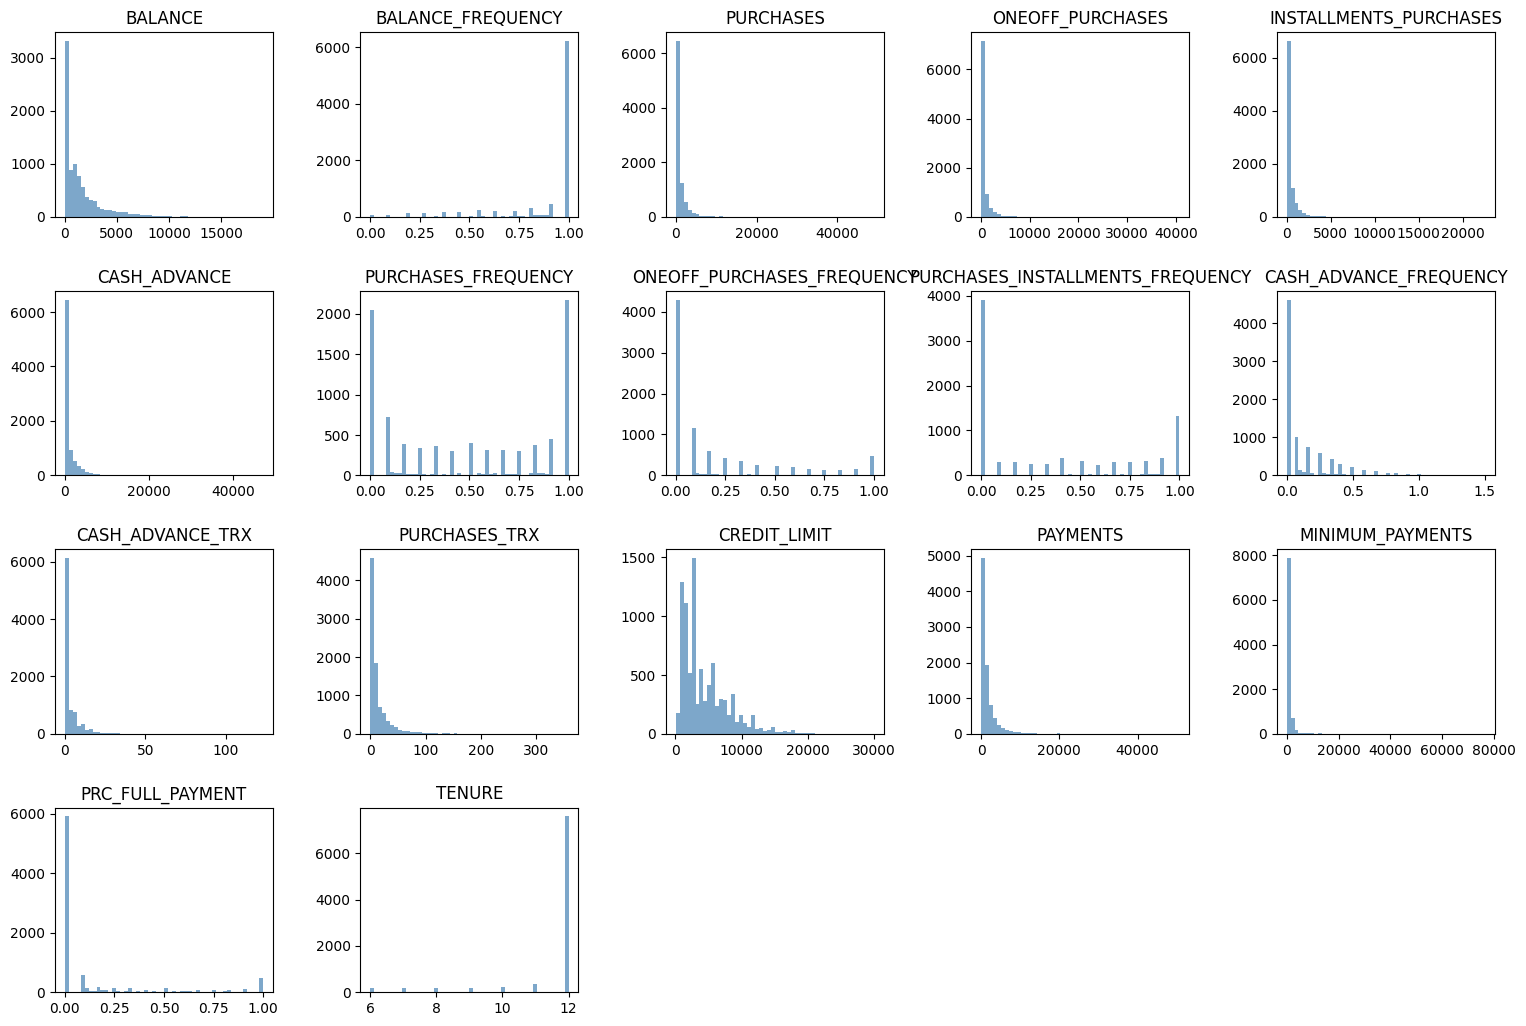

In [34]:
prep.plot_all_dist(cc_seg_imputed, (18, 12), num_var, 4, 5)

We will try the log transformation for simplicity. Since log transformation will not be valid for zero values, whenever the original variable is zero, we will use zero for the value of transformed variable.

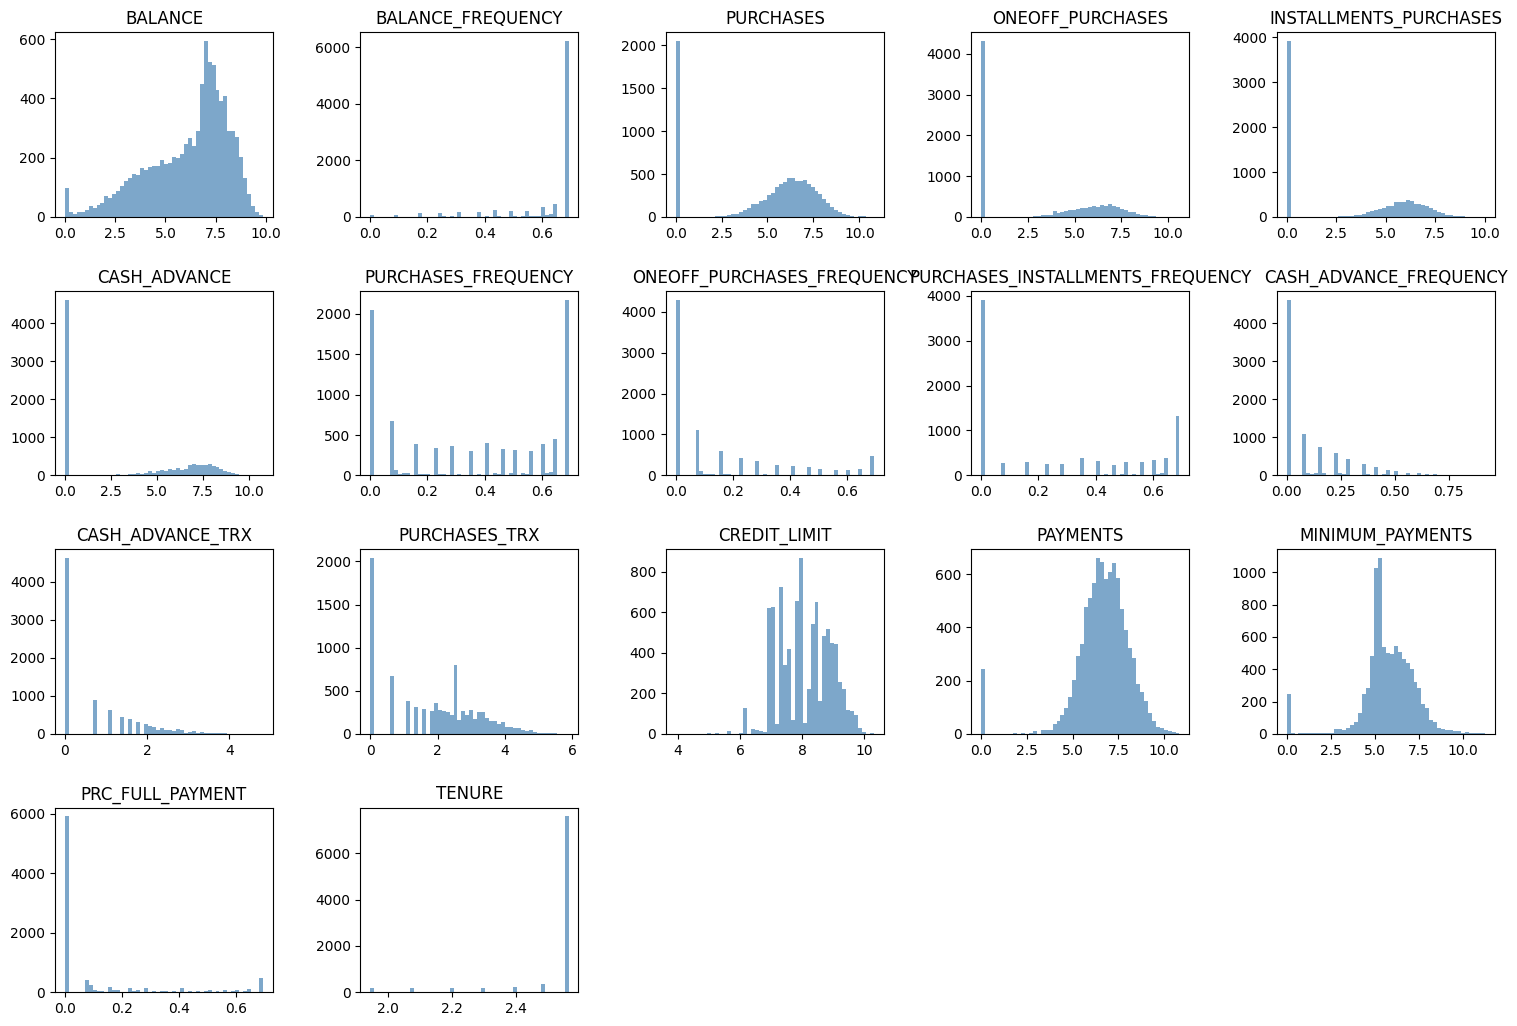

In [35]:
transformed_log = cc_seg_imputed[num_var].apply(lambda x: np.log(x + 1), axis = 1, result_type = 'broadcast')
prep.plot_all_dist(transformed_log, (18, 12), num_var, 4, 5)

As can be seen from the histogram above, most transformed variables become more symetrically distributed. Then next step is to standardize. 

In [36]:
transformed_df = transformed_log
# Standardize transformed variables
scaler = StandardScaler()
stand_trans_df = scaler.fit_transform(transformed_df)
print(stand_trans_df.mean(axis = 0))
print(stand_trans_df.std(axis = 0))

[ 0.00000000e+00 -2.85804899e-16  2.06414649e-16  0.00000000e+00
  1.03405800e-16  6.66878098e-17 -1.79421965e-16 -9.52682998e-17
 -1.04795130e-16 -1.22260985e-16 -5.79548824e-17  8.89170798e-17
  1.15592204e-15  3.49317099e-16  2.54048799e-16 -4.44585399e-17
  1.42267328e-15]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Clustering
In this section, we will use K-Means Clustering to segment the credit card consumers using the standardized behavior variables. Refer to /Concepts/Clustering.ipynb for technical details on the K-means algorithm and assumptions. 

### K-means Clustering

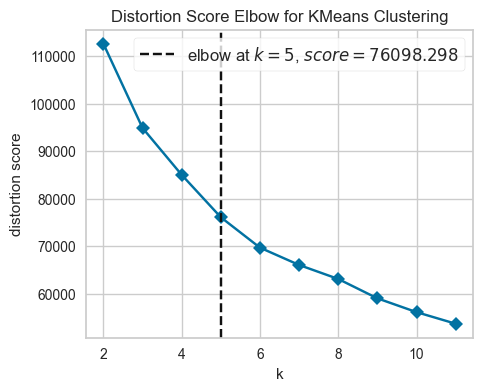

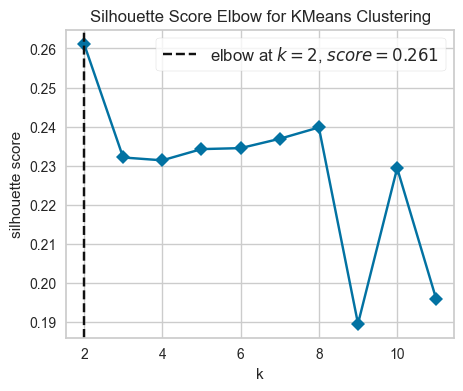

In [37]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
plt.figure(figsize=(5, 4))
# distortion: Sum of squared distance from each point to its assigned center
visualizer = KElbowVisualizer(model, k=(2,12), timings=False, metric='distortion', distance_metric='euclidean')

visualizer.fit(stand_trans_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
plt.show()

# Plot using silhouette score
plt.figure(figsize=(5, 4))
# silhouette score: average of all silhouette coefficients from all samples.
visualizer = KElbowVisualizer(model, k=(2,12), timings=False, metric='silhouette', distance_metric='euclidean')

visualizer.fit(stand_trans_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
plt.show()

By looking at the distortion score and the silhouette score, 5 clusters can be a good choice since:
1. Sum of inter-class distances (distortion) using the elbow method indicates k=5 is the best choice.
2. Even though the highest silhouette score is when k=2, the silhouette score when k=5 is around 0.235 which is not too far below 0.26 (k=2).
3. In the business context, the segmentation with enough granularity can help targeting customers for marketing purpose.

In [38]:
kmeans_final = KMeans(n_clusters = 5, init = 'k-means++', n_init = 10, max_iter = 300, random_state = 0).fit(stand_trans_df)
cc_seg_km = cc_seg_imputed.assign(SEGMENT = kmeans_final.labels_)
cc_seg_km_grouped = cc_seg_km.groupby('SEGMENT').mean()
cc_seg_km_grouped

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
SEGMENT,,,,,,,,,,,,,,,,,
0,1386.211764,0.961725,2576.276500,1793.079937,783.196563,39.545690,0.774191,0.567079,0.477272,0.009125,0.131731,32.943269,6013.192405,2461.808215,637.491201,0.233366,11.840385
1,2236.320347,0.934502,38.274893,35.851353,2.423540,1926.189484,0.028471,0.022815,0.004857,0.270150,6.272580,0.412313,4057.602759,1637.955653,1041.272472,0.030331,11.422843
2,138.365565,0.416921,297.750229,228.047521,69.702708,182.509241,0.229347,0.092079,0.130255,0.028151,0.537054,3.377859,3533.029532,669.773755,125.017143,0.145522,11.214090
3,472.696471,0.904580,632.139483,30.964115,601.175368,32.280736,0.780573,0.022587,0.737935,0.008255,0.125326,13.991123,3003.897328,804.077516,731.481719,0.314496,11.495561
4,3259.732230,0.973392,1430.169383,843.961945,586.207437,2628.556624,0.690993,0.310297,0.503577,0.342413,8.965542,22.720747,5801.579325,2925.407555,1490.533434,0.038867,11.470208


We can plot the average of the all behavior variables by the each clusters and summarize the characteristics for each cluster.

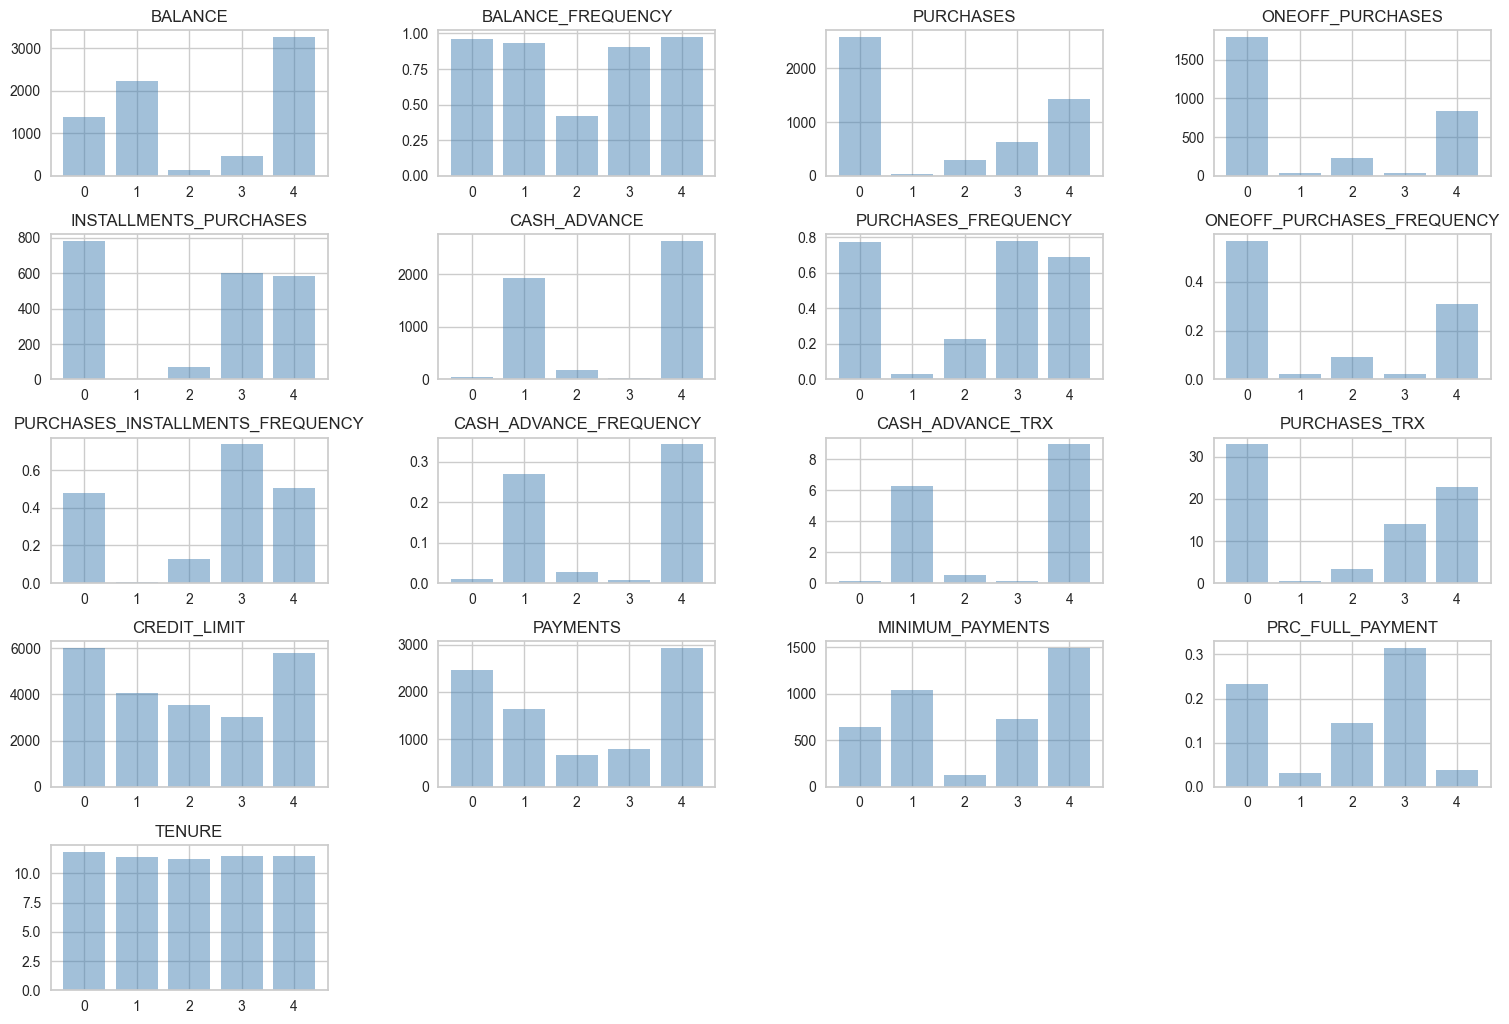

In [39]:
fig = plt.figure(figsize = (18, 12))
for index in range(1, len(num_var) + 1):
    ax = fig.add_subplot(5, 4, index)
    ax.bar(cc_seg_km_grouped.index.values, cc_seg_km_grouped[num_var[index - 1]].values, color = 'steelblue', alpha = 0.5)
    ax.set_title(num_var[index - 1])
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.4,
                        hspace=0.4)

* Cluster 0: High credit limit, Medium avaible funds, Medium full payment ratio and Heavy purchasers in amount and number of transactions.
* Cluster 1: Medium credit limit, Medium-high available funds, Low full payment ratio and Heavy cash advancer.
* Cluster 2: Medium credit limit, Low available funds, Medium full payment ratio, low cash advance and purchases in both transactions and amount.
* Cluster 3: Medium credit limit, Low available funds, High full payment ratio, low cash advance and medium-low purchases amount but relevantly high purchase frequency.
* Cluster 4: High credit limit, High available funds, Low full payment ratio, Medium purchases but high cash advances.

Note that the "low, medium and high" in the description is from a relative among the targeted consumer perspective instead of absolute term. For example, even the highest average customers' full payment ratio is 30% which is low from the absolute perspective.

### Visualize the clusters in two-dimension using PCA

In [40]:
# choose n_components = 2
num_comp = 2
pca_2comp = PCA(n_components = num_comp).fit(stand_trans_df)
col_names = list(cc_seg_imputed.drop(columns = "CUST_ID").columns)
component_dict = {'col_names': col_names}
for i in range(num_comp):
    component_dict[f'pcomp_{i+1}'] = list(pca_2comp.components_[i, :])
pd.DataFrame(component_dict)

,col_names,pcomp_1,pcomp_2
0,BALANCE,-0.110732,-0.428590
1,BALANCE_FREQUENCY,0.024479,-0.331997
2,PURCHASES,0.366801,-0.108000
3,ONEOFF_PURCHASES,0.213725,-0.205934
4,INSTALLMENTS_PURCHASES,0.327616,-0.061179
5,CASH_ADVANCE,-0.292443,-0.254097
6,PURCHASES_FREQUENCY,0.371879,-0.098664
7,ONEOFF_PURCHASES_FREQUENCY,0.224870,-0.208359
8,PURCHASES_INSTALLMENTS_FREQUENCY,0.316475,-0.055648
9,CASH_ADVANCE_FREQUENCY,-0.255765,-0.272987


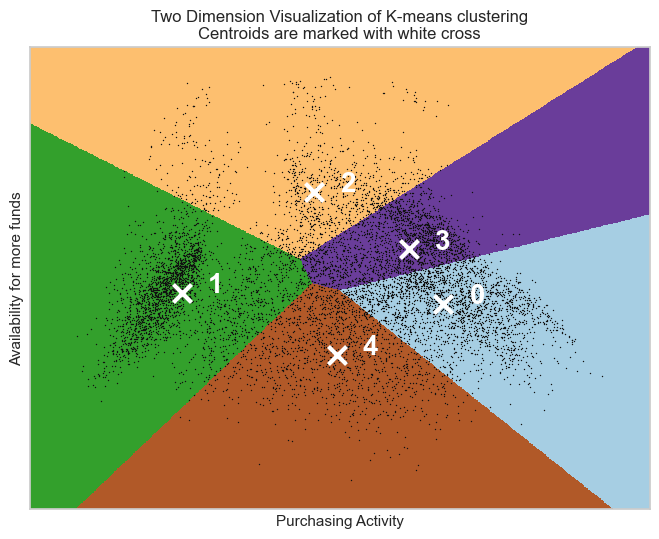

In [41]:
reduced_data = pca_2comp.transform(stand_trans_df)
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans_final.predict(pca_2comp.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize = (8, 6))
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = pca_2comp.transform(kmeans_final.cluster_centers_)
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
# Annotate the group
step_x = (centroids[:, 0].max() - centroids[:, 0].min())/10
step_y = (centroids[:, 1].max() - centroids[:, 1].min())/10
for c in range(len(centroids)):
    plt.annotate(text = f'{c}', xy = (centroids[c, 0],  centroids[c, 1]), xytext = (centroids[c, 0] + step_x,  centroids[c, 1]),
    color = 'w', fontsize = 20, fontweight = 'bold')

plt.title(
    "Two Dimension Visualization of K-means clustering\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.xlabel("Purchasing Activity")
plt.ylabel('Availability for more funds')
plt.show()


## Appendix

### A. Other Transformations
Other than Log-transformation, we can also use cubit-root transformation or box-cox transformation on the variables.

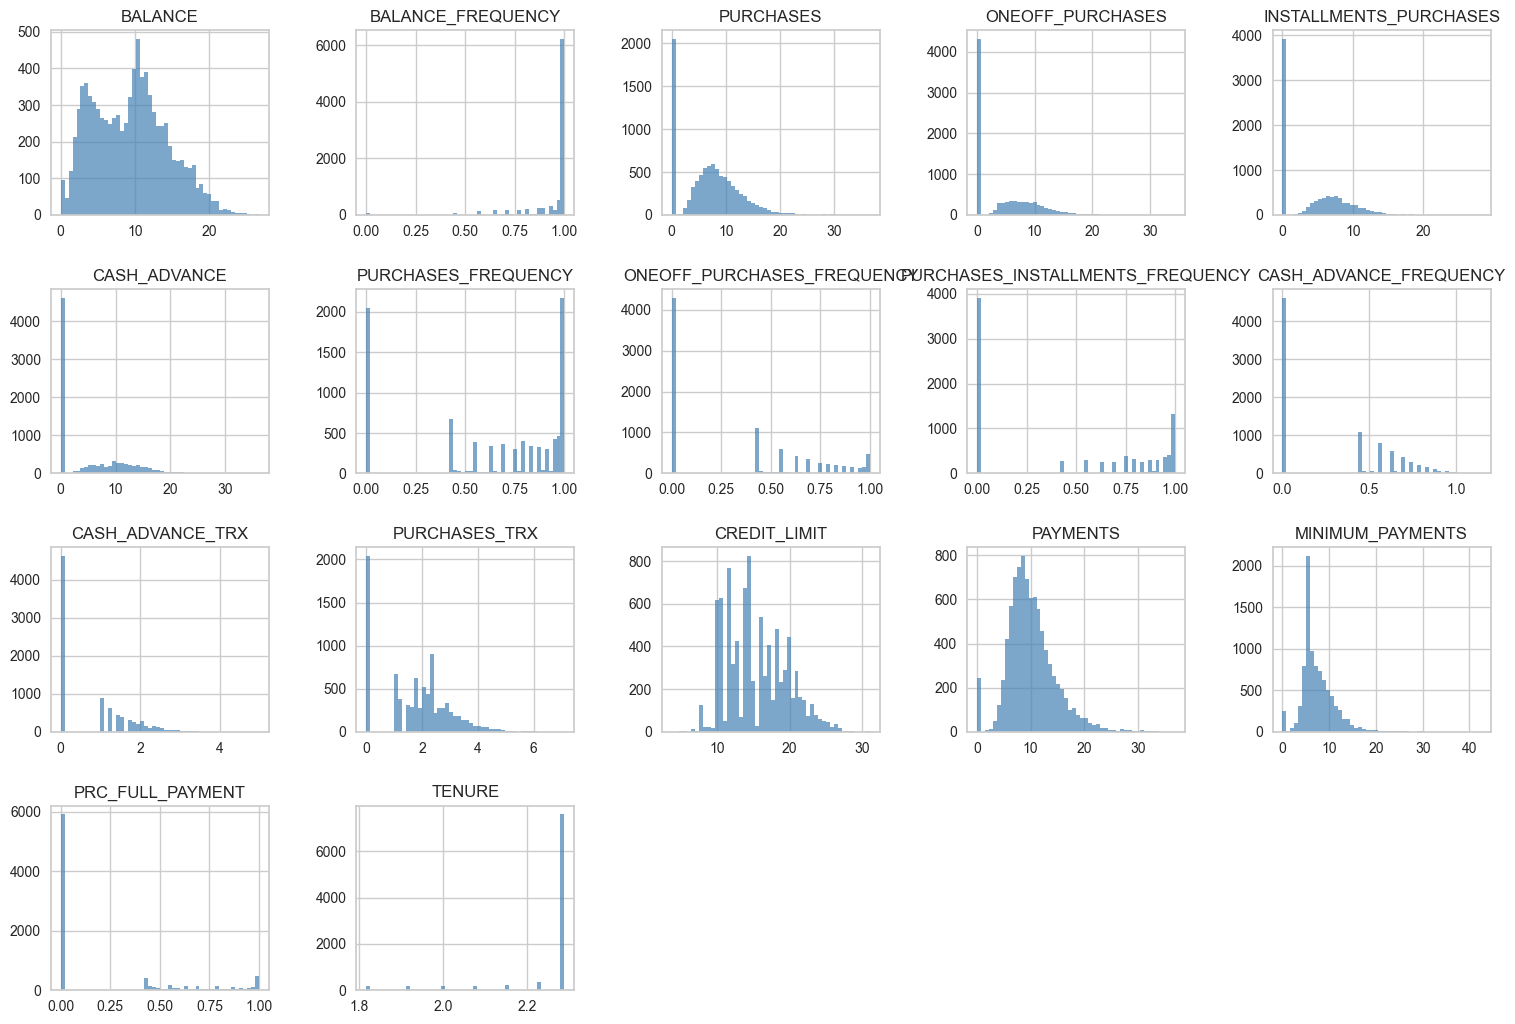

In [42]:
transformed_cbrt = cc_seg_imputed[num_var].apply(lambda x: np.cbrt(x), axis = 1, result_type = 'broadcast')
prep.plot_all_dist(transformed_cbrt, (18, 12), num_var, 4, 5)

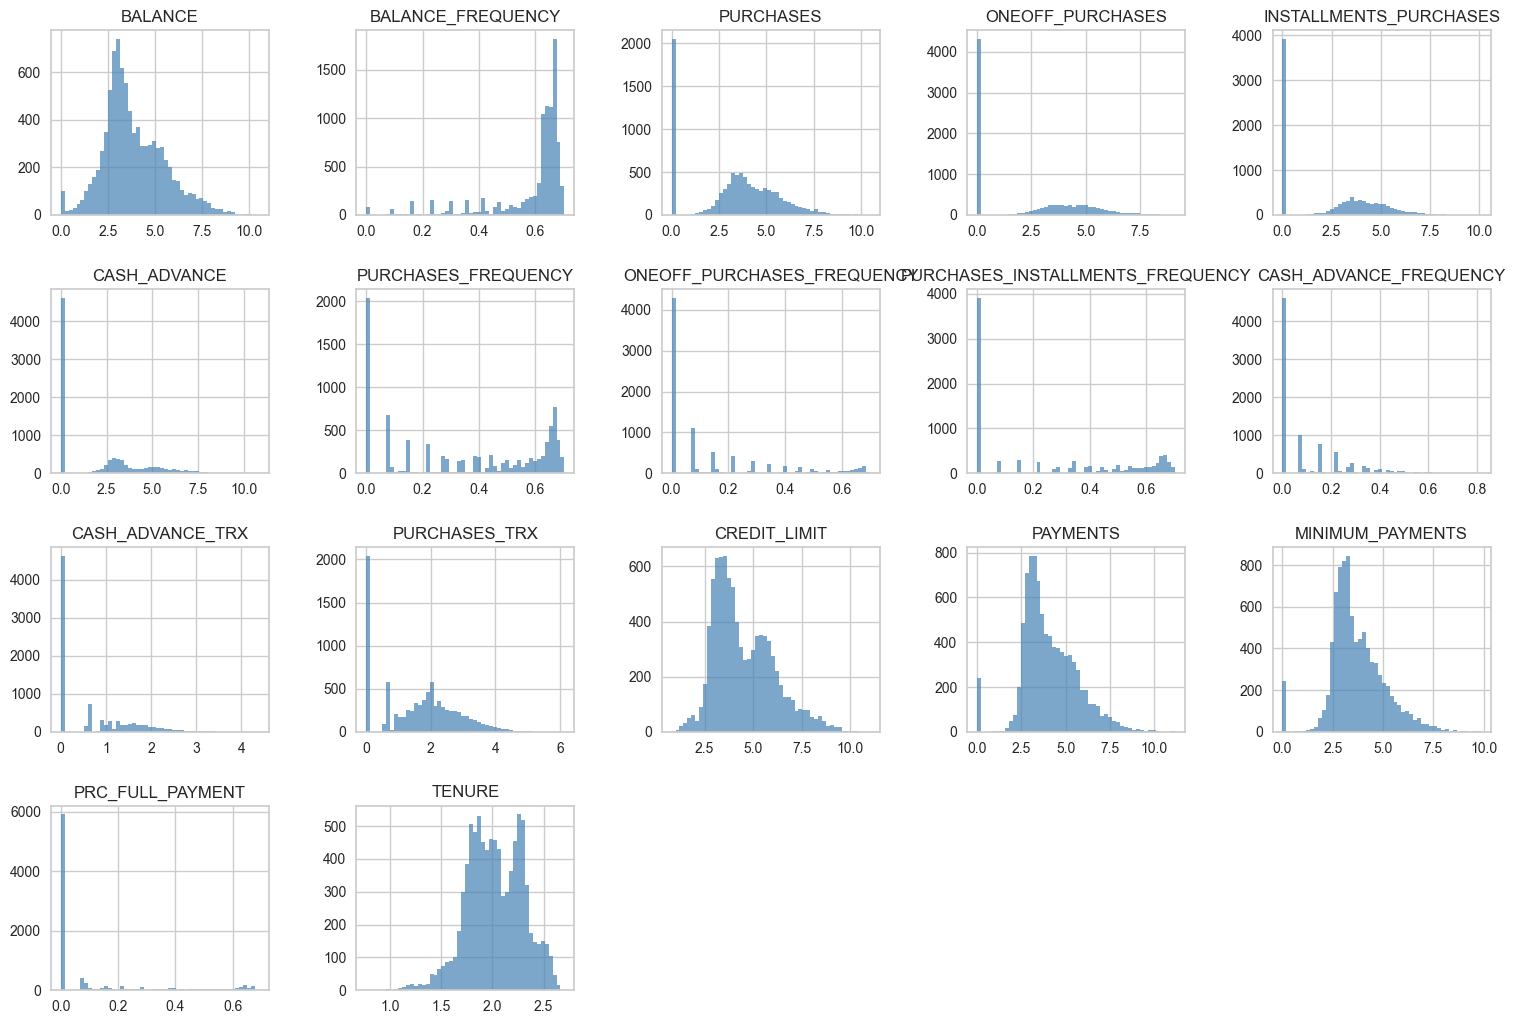

In [43]:
def box_cox_trans(x):
    xt, _ = scipy.stats.boxcox(x)
    return xt
transformed_boxcox = cc_seg_imputed[num_var].apply(lambda x: box_cox_trans(x + 1), axis = 1, result_type='broadcast')
prep.plot_all_dist(transformed_boxcox, (18, 12), num_var, 4, 5)

### B. Potential Feature Engineering
By looking at the columns, there are several categories to indicate the properties of the customer's credit card behavior:
|#| Category |Columns|
| --- | --- | --- |
| 1 | Current Funds for Debt| BALANCE, PAYMENTS|
| 2 | Potential Payback ability| BALANCE_FREQUENCY, MINIMUM_PAYMENTS, PRC_FULL_PAYMENTS, CASH_ADVANCE_FREQUENCY|
| 3 | Purchases Amount/Count| PURCHASES, ONEOFF_PURCHASES, INSTALLMENTS_PURCHASES, PURCHASES_TRX|
| 4 | Purchases Frequency| PURCHASES_FREQUENCY, ONEOFF_PURCHASES_FREQUENCY, INSTALLMENTS_PURCHASES_FREQUENCY|
| 5 | Cash Advance Behavior| CASH_ADVANCE, CASH_ADVANCE_TRX|
| 6 | Credit History| CREDIT_LIMIT, TENURE|

Based on the category, we can do some feature engineering:
1. debt_bal_ratio = (PURCHASES + CASH_ADVANCE) / (BALANCE + PAYMENTS)
2. util_ratio = (PURCHASES + CASH_ADVANCE) / CREDIT_LIMIT
3. pay_ratio = PAYMENTS / (PURCHASES + CASH_ADVANCE)
4. avg_spending_per_trx = CASH_ADVANCE / CASH_ADVANCE_TRX + PURCHASES / PURCHASES_TRX
5. avail_funds_freq = BALANCE_FREQUENCY + CASH_ADVANCE_FREQUENCY - PURCHASES_FREQUENCY
6. oneoff_amount_perc = ONEOFF_PURCHASES / PURCHASES
7. installments_amount_perc = INSTALLMENTS_PURCHASES / PURCHASES
8. oneoff_freq_perc = ONEOFF_FREQUENCY / PURCHASES_FREQUENCY
9. installments_freq_perc = INSTALLMENTS_FREQUENCY / PURCHASES_FREQUENCY
10. cash_ad_purchase_ratio = CASH_ADVANCE / PURCHASES
11. minpay_pay_ratio = MINIMUM_PAYMENTS / PAYMENTS


In [44]:
debt_bal_ratio = np.minimum(10, np.where((cc_seg_imputed['BALANCE'] + cc_seg_imputed['PAYMENTS']) > 0, 
(cc_seg_imputed['PURCHASES'] + cc_seg_imputed['CASH_ADVANCE']) / (cc_seg_imputed['BALANCE'] + cc_seg_imputed['PAYMENTS']), 
10))
util_ratio = np.minimum(10, (cc_seg_imputed['PURCHASES'] + cc_seg_imputed['CASH_ADVANCE']) / cc_seg_imputed['CREDIT_LIMIT'])
pay_ratio = np.minimum(10, np.where((cc_seg_imputed['PURCHASES'] + cc_seg_imputed['CASH_ADVANCE']) == 0, 10, cc_seg_imputed['PAYMENTS'] / (cc_seg_imputed['PURCHASES'] + cc_seg_imputed['CASH_ADVANCE'])))
avg_spending_per_trx = (cc_seg_imputed['CASH_ADVANCE'] / cc_seg_imputed['CASH_ADVANCE_TRX']).fillna(0) + (cc_seg_imputed['PURCHASES'] / cc_seg_imputed['PURCHASES_TRX']).fillna(0)
avail_funds_freq = cc_seg_imputed['BALANCE_FREQUENCY'] + cc_seg_imputed['CASH_ADVANCE_FREQUENCY'] - cc_seg_imputed['PURCHASES_FREQUENCY']
oneoff_amount_perc = np.where(cc_seg_imputed['PURCHASES'] == 0, 0, cc_seg_imputed['ONEOFF_PURCHASES'] / cc_seg_imputed['PURCHASES'])
installments_amount_perc = np.where(cc_seg_imputed['PURCHASES'] == 0, 0, cc_seg_imputed['INSTALLMENTS_PURCHASES'] / cc_seg_imputed['PURCHASES'])
oneoff_freq_perc = np.where(cc_seg_imputed['PURCHASES_FREQUENCY'] == 0, 0, cc_seg_imputed['ONEOFF_PURCHASES_FREQUENCY'] / cc_seg_imputed['PURCHASES_FREQUENCY'])
installments_freq_perc = np.where(cc_seg_imputed['PURCHASES_FREQUENCY'] == 0, 0, cc_seg_imputed['PURCHASES_INSTALLMENTS_FREQUENCY'] / cc_seg_imputed['PURCHASES_FREQUENCY'])
cash_ad_purchase_ratio = np.minimum(10, np.where(cc_seg_imputed['PURCHASES'] == 0, 10, cc_seg_imputed['CASH_ADVANCE'] / cc_seg_imputed['PURCHASES']))
minpay_pay_ratio = np.minimum(10, np.where(cc_seg_imputed['PAYMENTS'] == 0, 0, cc_seg_imputed['MINIMUM_PAYMENTS'] / cc_seg_imputed['PAYMENTS']))

In [45]:
# Add all the additional features to the imputed dataset
cc_seg_analysis = cc_seg_imputed.copy()

cc_seg_analysis['debt_bal_ratio'] = debt_bal_ratio
cc_seg_analysis['util_ratio'] = util_ratio
cc_seg_analysis['pay_ratio'] = pay_ratio
cc_seg_analysis['avg_spending_per_trx'] = avg_spending_per_trx
cc_seg_analysis['avail_funds_freq'] = avail_funds_freq
cc_seg_analysis['oneoff_amount_perc'] = oneoff_amount_perc
cc_seg_analysis['oneoff_freq_perc'] = oneoff_freq_perc
cc_seg_analysis['installments_amount_perc'] = installments_amount_perc
cc_seg_analysis['installments_freq_perc'] = installments_freq_perc
cc_seg_analysis['cash_ad_purchase_ratio'] = cash_ad_purchase_ratio
cc_seg_analysis['minpay_pay_ratio'] = minpay_pay_ratio

cc_seg_analysis.describe()


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,util_ratio,pay_ratio,avg_spending_per_trx,avail_funds_freq,oneoff_amount_perc,oneoff_freq_perc,installments_amount_perc,installments_freq_perc,cash_ad_purchase_ratio,minpay_pay_ratio
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,...,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.505016,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,...,0.500909,1.523498,282.815677,0.522064,0.379520,0.375957,0.392323,0.475204,3.183792,0.804070
std,2081.531879,0.236904,2136.737531,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,...,0.563723,1.904002,551.174546,0.530409,0.425591,0.435479,0.429009,0.448615,4.389523,1.319846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,128.281915,0.888889,39.807500,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,...,0.128379,0.537900,47.118333,0.060606,0.000000,0.000000,0.000000,0.000000,0.000000,0.147677
50%,873.385231,1.000000,362.420000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,...,0.336431,0.961832,111.240830,0.416666,0.111363,0.090909,0.185117,0.500002,0.000000,0.442721
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,...,0.710115,1.563859,320.199937,1.000000,0.874174,1.000000,1.000000,1.000000,10.000000,1.025730
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,...,10.000000,10.000000,14840.121410,2.500000,1.000000,1.199999,1.000000,1.250002,10.000000,10.000000
